# King County House Sales Analysis 

## Introduction 
Here we will be looking into the King County House Sales dataset to find information on how home renovations might increase the estimated value of homes (and by what amount) for the magazine 'Home Owners Yearly', who wants to put out an article on what renovations will or will not be likely to improve the value of middle class homes.

In order to do this, we will be looking at a data set on houses and housing prices from [King County in Washington State](https://en.wikipedia.org/wiki/King_County,_Washington).

The dataset covers alot of information, so we will pick a few questions to focus on.

- Will adding bedrooms or bathrooms lead to an associated increase in the value of the home?
- Will increasing the living area size lead to an associated increase in the value of the home?
- Is the grade or condition rating of the house associated with the value of the home?

In [1]:
# importing required packages
import warnings
import zipfile
import seaborn as sns
import sqlite3 as sql
import pandas as pd
import numpy as np
import copy
import pylab
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
warnings.filterwarnings("ignore")

## Looking at the dataset

### Limitations of Dataset

There are some limitations inherent to this dataset. First and foremost, this dataset is all from King County, WA. This is a fairly affluent and densely populated area [(Wikipedia page)](https://en.wikipedia.org/wiki/King_County,_Washington), and as such the recommendations and conclusions from this data may not hold true for other areas with different characteristics (e.g. rural areas). More information and analysis is necessary to determine what neighborhoods and counties can use these recommendations. 

Additionally, there are many types of renovations that aren't included in the dataset (e.g. renovating the plumbing, new roof, adding a deck, ect.), which limits the specificity of the recommendations. 

### Why We Used This Dataset

Despite the above limitations, this dataset does represent a middle and upper class neighborhood, which is the demographic that the magazine is trying to appeal to. It does contain the information on bedrooms and bathrooms (which were some of the magazines specific questions that they wanted answers to) and was easily available. 



In [2]:
# lets take an initial look at the data in the `kc_house_data.csv` dataset
df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# So above we see there are 21 columns, and it looks like 'price'
# may be a good contender for our dependant variable, as we
# want to know what improvements will increase the selling price
# of a home.

In [4]:
# looking into the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
df.shape

(21597, 21)

#### Dataset Size
So we see above that starting off we have 21 columns, and 21,597 rows (each representing a different home) in total.


## Preprocessing 

### Check for missing values

In [7]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

 Lets peek into the three columns with NaN data, starting with the `waterfront` data: 

In [8]:
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Seems like we could recode these NaN's as NO - it could be that the NaN's are in areas where being on the waterfront isn't possible? Regardless, it's improbable that a homeowner or could change the location of a home to improve the homes value, but having a waterfront propety could affect the value of the renovations, so we'll replace all the NaN's with `NO`. 

In [9]:
df.waterfront.replace({np.nan: 'NO'}, inplace=True)
df['waterfront'].value_counts()
# df.head()

NO     21451
YES      146
Name: waterfront, dtype: int64

Now let's deal with the NaN's in `view`. Here we are not missing so many, so we could just drop those rows completely from the dataset, but let's peak into the data and see if we can convert the NaN's into another option instead. 


In [10]:
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

As we have the NONE value category (which makes up most of the data) we can just convert the NaN's into NONE's. 

In [11]:
df.view.replace({np.nan: 'NONE'}, inplace=True)
df['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Finally, lets look at `yr_renovated`. 

In [12]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

While we are looking at renovations, we are less interested in past renovations, and more concerned with future improvements we can do, but knowing when the last renovations were may still be usefull data. There already seems to be a missing data value (0.0) so we'll replace all our NaN's with that. 

In [13]:
df.yr_renovated.replace({np.nan: 0.0}, inplace=True)
df['yr_renovated'].value_counts()
# df.head()

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

### Dropping Columns 

When we looked into the NaN values, we saw that there are some columns that are irrelevant to the buisness question we are trying to answer. 

- (Just a reminder of the question: How could home renovations possibly increase the estimated value of homes?)

As such, we'll quickly peek into the `column_names.md.txt` file, to see what the column names mean and see if there are any more we can drop. 



Here's a copy-paste of the information in `column_names.md.txt`:

#### Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

- We should also probably drop `id` (as we don't need to know specific houses identifiers), `date` (as it's not important when the house was last sold), `lat`, `long`, and `zipcode` (as we can't change where the house is located). 

- The rest of the categories are things that could possibly be changed in the suggested renovations (e.g. you could add on another bedroom, which would change the value in `bedrooms`) or may have implications for the renovations (e.g. knowing when the house was built could affect the renovations.) 

- The `yr_renovated` and `yr_built` aren't directly related to our questions, and will likely add a lot of bulk/noise to our dataset. Additionally, we aren't asking questions about the lot sizes (or basement sizes), so lets drop `sqft_lot`, `sqft_above`, `sqft_basement`, and `sqft_15 too`.

Lets drop those variables now. 

In [14]:
df.drop(columns=['id', 'date', 'lat', 'long', 'zipcode'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1180,0.0,1955,0.0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,0.0,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,1800,7503


Great! Now our dataframe only includes variables that will (hopefully) allow us to answer our buisness question. Dealing with fewer variables will simplfy the analysis process. 

### Handeling non-numeric values

Lets look into the types of data in our dataframe again, now that we've altered it a little. 

In [16]:
# looking into the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  object 
 7   view           21597 non-null  object 
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 2.6+ MB


We see we have 5 columns listed as objects - `waterfront`, `view`, `condition`, `grade`, and `sqft_basement`. 
- We've already looked into `waterfront` and seen that this category is binary - either `YES` or `NO`. As such, we can recode these as 1 and 0 respectivly. 
- We also already looked in `view`, so we can also recode these values on a scale of 0-4 (0 = `NONE`, ... 4 = `EXCELLENT`). 
- We'll have to look into `condition`, `grade`, and `sqft_basement` to better know how to handle them. 

Let's start by recoding `waterfront`: 

In [17]:
df['waterfront'] = df['waterfront'].replace(
    to_replace=['YES', 'NO'],
    value=[1, 0])

In [18]:
# checking that the recode worked
df['waterfront'].value_counts()

0    21451
1      146
Name: waterfront, dtype: int64

Now we'll recode `view`:

In [19]:
df['view'] = df['view'].replace(
    to_replace=['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'],
    value=[0, 1, 2, 3, 4])

In [20]:
# checking that the recode worked
df['view'].value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

Lets look into `condition`:

In [21]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

This is category is a little less intuitive to know how to classify, so I looked into the dictonary and went to the [link](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) mentioned there, searched for BUILDING CONDITION and found this scale to work with: 

1 = Poor, 2 = Fair, 3 = Average, 4 = Good, 5= Very Good

As such, we will recode the condition column as they reccomended!

In [22]:
df['condition'] = df['condition'].replace(
    to_replace=['Poor', 'Fair', 'Average', 'Good', 'Very Good'],
    value=[1, 2, 3, 4, 5])

In [23]:
# check the changes we made
df['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

Looking into `grade`:

In [24]:
df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

So this is messier than the previous variables. Once again I looked in the `column_names.md.txt` dictionary and found this under the heading BUILDING GRADE: 

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

- 1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

- 4 Generally older, low quality construction. Does not meet code.

- 5 Low construction costs and workmanship. Small, simple design.

- 6 Lowest grade currently meeting building code. Low quality materials and simple designs.

- 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

- 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

- 9 Better architectural design with extra interior and exterior design and quality.

- 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

- 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

- 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

- 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc. 

From this we see that the values do have a scale, indicated by the numbers at the prefix of the values shown above, but the scale starts at 3 (as 1-3 seem to all be lumped into one category). As such, let's recode these values from 1 (Poor) to 11 (Mansion) according to the above scale. 

In [25]:
df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [26]:
df['grade'] = df['grade'].replace(
    to_replace=['3 Poor', '4 Low', '5 Fair', '6 Low Average',
                '7 Average', '8 Good', '9 Better', '10 Very Good',
                '11 Excellent', '12 Luxury', '13 Mansion'],
    value=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [27]:
# checking on the changes we made above
df['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

Because the magazine is focused on middle class homes, let's use this category to subset the dataset by removing high grade homes *(12 and above)* and the low grade homes *(5 and below)*

In [28]:
drop_grade = df[(df['grade'] >= 12) | (df['grade'] <= 6)].index
df.drop(drop_grade, inplace=True)
df  # we see we dropped around 300 rows

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0.0,1955,0.0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400.0,1951,1991.0,1690,7639
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910.0,1965,0.0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0.0,1987,0.0,1800,7503
5,1230000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530.0,2001,0.0,4760,101930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0.0,2009,0.0,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0.0,2014,0.0,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0.0,2009,0.0,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0.0,2004,0.0,1410,1287


Finally, lets look at our last object category `sqft_basement`:

In [29]:
df['sqft_basement'].value_counts()

0.0       10999
?           406
600.0       204
700.0       195
500.0       192
          ...  
1548.0        1
1024.0        1
2300.0        1
2720.0        1
1481.0        1
Name: sqft_basement, Length: 289, dtype: int64

So it seems like the only string variable that we have here is `?` - so lets turn all of those into zeros, and recast this category as a float. 

In [30]:
df['sqft_basement'] = df['sqft_basement'].replace(
    to_replace=['?'],
    value=[0.0]).astype(float)

In [31]:
# Once again, checking what we did
df['sqft_basement'].value_counts()

0.0       11405
600.0       204
700.0       195
500.0       192
800.0       192
          ...  
2130.0        1
1548.0        1
915.0         1
508.0         1
1890.0        1
Name: sqft_basement, Length: 288, dtype: int64

In [32]:
# Now we see that there are no more `object` Dtypes - woohoo!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19187 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19187 non-null  float64
 1   bedrooms       19187 non-null  int64  
 2   bathrooms      19187 non-null  float64
 3   sqft_living    19187 non-null  int64  
 4   sqft_lot       19187 non-null  int64  
 5   floors         19187 non-null  float64
 6   waterfront     19187 non-null  int64  
 7   view           19187 non-null  int64  
 8   condition      19187 non-null  int64  
 9   grade          19187 non-null  int64  
 10  sqft_above     19187 non-null  int64  
 11  sqft_basement  19187 non-null  float64
 12  yr_built       19187 non-null  int64  
 13  yr_renovated   19187 non-null  float64
 14  sqft_living15  19187 non-null  int64  
 15  sqft_lot15     19187 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.5 MB


Now that we have all our data as integers or floats, we still have to deal with the categorical variables, otherwise when we try to build our models it will inteprete the information provided incorrectly. We will use one hot encoding (OHE) to do this. 

The columns we will use this on are as they are categorical are: `view`, `condition`, and  `grade`.

In [33]:
# OHE the above categories
cat_var = ['view', 'condition', 'grade']
preprocessed_df = pd.get_dummies(
    df, prefix=cat_var, columns=cat_var, drop_first=True)

In [34]:
# Look at the pretty preprocessed data!
preprocessed_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,view_3,view_4,condition_2,condition_3,condition_4,condition_5,grade_8,grade_9,grade_10,grade_11
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0.0,1955,...,0,0,0,1,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400.0,1951,...,0,0,0,1,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910.0,1965,...,0,0,0,0,0,1,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0.0,1987,...,0,0,0,1,0,0,1,0,0,0
5,1230000.0,4,4.50,5420,101930,1.0,0,3890,1530.0,2001,...,0,0,0,1,0,0,0,0,0,1


### Check for Multicollinearity 

In [35]:
# Now lets drop our dependant variable 'price' to look at
# the relationships between our predictors
predict = preprocessed_df.drop('price', axis=1)
# and then we will look at the correlations between the predictors
corr_predictors = predict.corr().abs().stack(
).reset_index().sort_values(0, ascending=False)
corr_predictors['pairs'] = list(
    zip(corr_predictors.level_0, corr_predictors.level_1))
corr_predictors.set_index(['pairs'], inplace=True)
corr_predictors.drop(columns=['level_1', 'level_0'], inplace=True)
corr_predictors.columns = ['correlations']
corr_predictors[(corr_predictors.correlations > .75)
                & (corr_predictors.correlations < 1)]

,correlations
pairs,
"(sqft_above, sqft_living)",0.855425
"(sqft_living, sqft_above)",0.855425
"(condition_4, condition_3)",0.826058
"(condition_3, condition_4)",0.826058


For 3 out out of 4 of the above high correlations, we see that `sqft_living` is one of the variables, along with some of our OHE variables - `condition_3` and `condition_4`. For now, we will leave them in, but it's something to keep in mind as we build our model later. 

In [36]:
preprocessed_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,view_3,view_4,condition_2,condition_3,condition_4,condition_5,grade_8,grade_9,grade_10,grade_11
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0.0,1955,...,0,0,0,1,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400.0,1951,...,0,0,0,1,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910.0,1965,...,0,0,0,0,0,1,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0.0,1987,...,0,0,0,1,0,0,1,0,0,0
5,1230000.0,4,4.50,5420,101930,1.0,0,3890,1530.0,2001,...,0,0,0,1,0,0,0,0,0,1


### Checking Variable Distributions

In [37]:
""" Just by looking at the `price` column, we see we have 
19,187 data points, with a mean sale price of 560,000$ (rounded
up)"""
preprocessed_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,view_3,view_4,condition_2,condition_3,condition_4,condition_5,grade_8,grade_9,grade_10,grade_11
count,1.918700e+04,19187.000000,19187.000000,19187.000000,1.918700e+04,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,...,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000,19187.000000
mean,5.599148e+05,3.456090,2.212019,2171.185230,1.505365e+04,1.538411,0.006358,1861.192995,303.434461,1974.426695,...,0.025069,0.014437,0.004795,0.666545,0.254495,0.073748,0.316099,0.136290,0.059103,0.020795
std,3.403288e+05,0.892121,0.714116,856.287271,3.942499e+04,0.546527,0.079488,792.690047,444.662335,28.264321,...,0.156339,0.119286,0.069081,0.471460,0.435588,0.261367,0.464964,0.343105,0.235823,0.142702
min,9.000000e+04,1.000000,0.500000,550.000000,5.200000e+02,1.000000,0.000000,550.000000,0.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.450000e+05,3.000000,1.750000,1540.000000,5.001000e+03,1.000000,0.000000,1270.000000,0.000000,1957.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.788300e+05,3.000000,2.250000,2020.000000,7.670000e+03,1.500000,0.000000,1650.000000,0.000000,1978.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.675000e+05,4.000000,2.500000,2630.000000,1.076750e+04,2.000000,0.000000,2300.000000,600.000000,1999.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,7.060000e+06,33.000000,7.500000,10040.000000,1.074218e+06,3.500000,1.000000,8020.000000,3260.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Basic Model

To start off we will pick an independent variable that should be important (`sqft_living`) and create a simple linear model with our dependent variable `price` as our baseline model. (Remember, one of our initial questions was if increasing the living space of a home increased the home's value!)

After we've looked into this, we will add more variables to see if we can improve on the model. 

Before we start on this, let's check if the relationship between `price` and `sqft_living` meets the criteria for linear regression. 

Text(0.5, 1.0, 'Linearity and Homoscedasticity check')

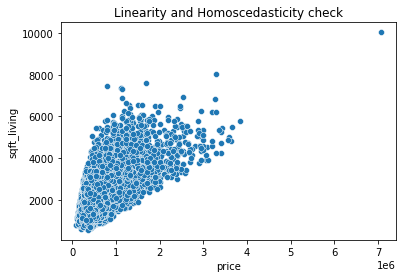

In [38]:
# check for linearity and Homoscedasticity
sns.scatterplot(x=preprocessed_df['price'], y=preprocessed_df['sqft_living'])
plt.title("Linearity and Homoscedasticity check")

In [39]:
# create predictors
predictors = preprocessed_df['sqft_living']
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
baseline_model = sm.OLS(preprocessed_df['price'], predictors_int).fit()

# check model
baseline_model.params

const         -10517.576406
sqft_living      262.728564
dtype: float64

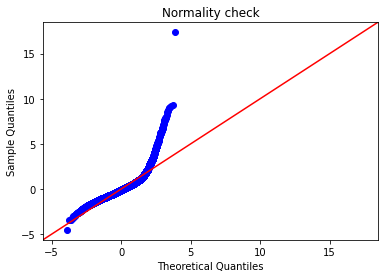

In [40]:
# check normality assumption

residuals = baseline_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Normality check")
fig.show()

So we see that 2/3 of the assumptions of linearity are violated here - the residuals aren't normally distributed, and the data isn't homoscedastic. We'll get a summary of the model as is, see if performing a log transformation on `price` and `sqft_living` will help with these conditions, and then see if adding in some other variables to our model will improve our  R^2 . 

In [41]:
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.489e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:01   Log-Likelihood:            -2.6611e+05
No. Observations:               19187   AIC:                         5.322e+05
Df Residuals:                   19185   BIC:                         5.322e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.052e+04   5025.165     -2.093      0.036   -2.04e+04    -667.813
sqft_living   262.7286      2.153    122.024      0.000     258.508     266.949
==============================================================================
Omnibus:                    10750.808   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           198145.051
Skew:                           2.308   Prob(JB):                         0.00
Kurtosis:                      18.052   Cond. No.                     6.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# apply logarithmic function to independant variable
preprocessed_df['log_sqft_living'] = np.log(preprocessed_df['sqft_living'])


# re-create the model with `log_sqft_living`
# create predictors
predictors = preprocessed_df['log_sqft_living']
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
log_model1 = sm.OLS(preprocessed_df['price'], predictors_int).fit()

# check model
print(log_model1.params)
log_model1.summary()

const             -3.518415e+06
log_sqft_living    5.358689e+05
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.065e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:01   Log-Likelihood:            -2.6739e+05
No. Observations:               19187   AIC:                         5.348e+05
Df Residuals:                   19185   BIC:                         5.348e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.518e+06   3.96e+04    -88.917      0.000    -3.6e+06   -3.44e+06
log_sqft_living  5.359e+05   5192.767    103.195      0.000    5.26e+05    5.46e+05
==============================================================================
Omnibus:                    12908.156   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           395597.719
Skew:                           2.804   Prob(JB):                         0.00
Kurtosis:                      24.527   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

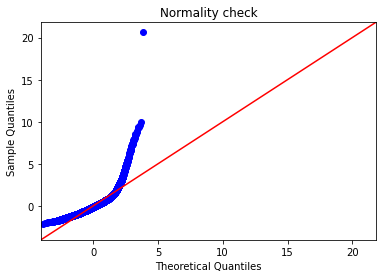

In [43]:
residuals = log_model1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Normality check")
fig.show()

Ooph! So that lowered our R^2 signifigantly. Lets see what happens if we perform a log function just on `price`.

In [44]:
# apply logarithmic function to dependant variable
preprocessed_df['log_price'] = np.log(preprocessed_df['price'])


# re-create the model with `sqft_living`
# create predictors
predictors = preprocessed_df['sqft_living']
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
log_model2 = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
print(log_model2.params)
log_model2.summary()

const          12.284253
sqft_living     0.000378
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                 1.456e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:02   Log-Likelihood:                -8204.9
No. Observations:               19187   AIC:                         1.641e+04
Df Residuals:                   19185   BIC:                         1.643e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2843      0.007   1682.175      0.000      12.270      12.299
sqft_living     0.0004   3.13e-06    120.678      0.000       0.000       0.000
==============================================================================
Omnibus:                       77.133   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.178
Skew:                           0.089   Prob(JB):                     4.26e-15
Kurtosis:                       2.774   Cond. No.                     6.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

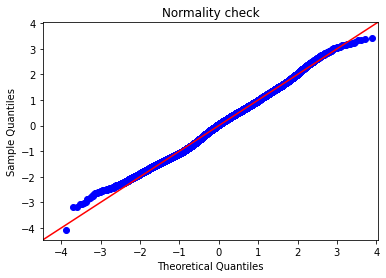

In [45]:
residuals = log_model2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Normality check")
fig.show()

Wow! Thats looking way better, and our R^2 is slighly higher than our baseline model. Lets check what happens if we apply the log function to both and throw them in our model. 

In [46]:
# re-create the model with `sqft_living`
# create predictors
predictors = preprocessed_df['log_sqft_living']
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
log_model3 = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
print(log_model3.params)
log_model3.summary()

const              6.870561
log_sqft_living    0.819047
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:02   Log-Likelihood:                -8743.6
No. Observations:               19187   AIC:                         1.749e+04
Df Residuals:                   19185   BIC:                         1.751e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8706      0.055    124.156      0.000       6.762       6.979
log_sqft_living     0.8190      0.007    112.784      0.000       0.805       0.833
==============================================================================
Omnibus:                      110.445   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.414
Skew:                           0.141   Prob(JB):                     9.51e-23
Kurtosis:                       2.783   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So takign the log of both seems to have lowered our R^2 a bit, and will make interpretation a bit more challenging, so lets stick with `log_model2` with only `price` being transformed.

## Adding Features

### Bathrooms and Bedrooms
Lets start by adding `bathrooms` to the model. 

First we'll check for linearity and homoscedasticity in `bathrooms` and `bedrooms` compared to `price`, as these are the only continuous variables we are looking at.


''

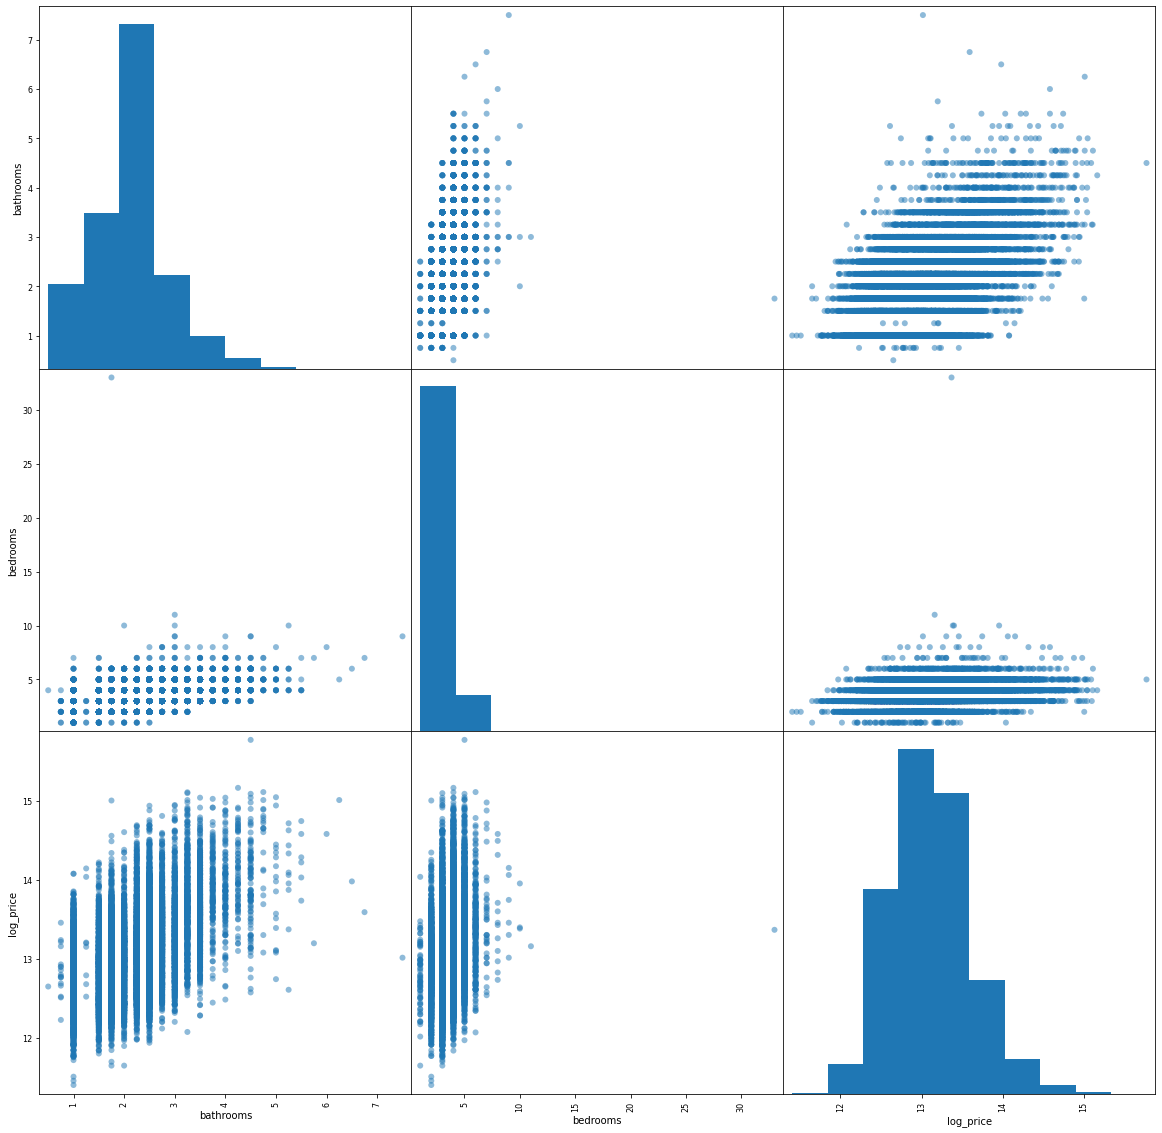

In [47]:
col = ['bathrooms', 'bedrooms', 'log_price']
pd.plotting.scatter_matrix(
    preprocessed_df[col], figsize=(20, 20), grid=True, marker='o')

We see that there is linearity and homoscedasticity in `bathrooms` and `log_price`- lets check for normality in `bathrooms` and `bedrooms`.

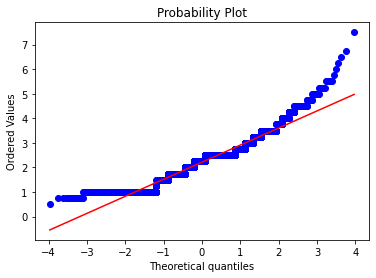

In [48]:
stats.probplot(preprocessed_df['bathrooms'], dist="norm", plot=pylab)
pylab.show()

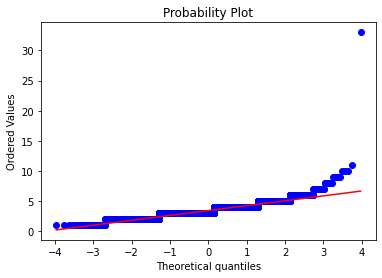

In [49]:
stats.probplot(preprocessed_df['bedrooms'], dist="norm", plot=pylab)
pylab.show()

Looks like it's not perfectly normal, but it's better than it was for `sqft_living`. 

In [50]:
# create predictors
predictors = preprocessed_df[['sqft_living', 'bathrooms']]
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
second_model = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     7285.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:03   Log-Likelihood:                -8202.5
No. Observations:               19187   AIC:                         1.641e+04
Df Residuals:                   19184   BIC:                         1.643e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2734      0.009   1392.043      0.000      12.256      12.291
sqft_living     0.0004   4.43e-06     83.731      0.000       0.000       0.000
bathrooms       0.0117      0.005      2.197      0.028       0.001       0.022
==============================================================================
Omnibus:                       80.139   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.910
Skew:                           0.092   Prob(JB):                     1.09e-15
Kurtosis:                       2.772   Cond. No.                     8.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we see here that in this model, our R^2 has dropped a little. That may be due to high multicollinearity between `sqft_living` and `bathrooms`. If we try building off of this model, we get some really weird results (the bathrooms coefficient becomes negative). Lets build another model with `log_price` with `bedrooms` and `bathrooms` as predictors, without `sqft_living`.

In [51]:
# create predictors
predictors = preprocessed_df[['bedrooms', 'bathrooms']]
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
third_model = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
third_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     2852.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:04   Log-Likelihood:                -11126.
No. Observations:               19187   AIC:                         2.226e+04
Df Residuals:                   19184   BIC:                         2.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2845      0.013    923.157      0.000      12.258      12.311
bedrooms       0.0449      0.004     11.396      0.000       0.037       0.053
bathrooms      0.3003      0.005     60.999      0.000       0.291       0.310
==============================================================================
Omnibus:                      185.055   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.243
Skew:                           0.243   Prob(JB):                     4.89e-42
Kurtosis:                       3.030   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, here we see a lower R^2 as we took out `sqft_living`, but we can see that adding bathrooms seems to be associated with more significant price increases in homes, compared to bedrooms. 

### Grade and Condition

Before dealing with our final question, lets glance at our current dataframe. 

In [52]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19187 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            19187 non-null  float64
 1   bedrooms         19187 non-null  int64  
 2   bathrooms        19187 non-null  float64
 3   sqft_living      19187 non-null  int64  
 4   sqft_lot         19187 non-null  int64  
 5   floors           19187 non-null  float64
 6   waterfront       19187 non-null  int64  
 7   sqft_above       19187 non-null  int64  
 8   sqft_basement    19187 non-null  float64
 9   yr_built         19187 non-null  int64  
 10  yr_renovated     19187 non-null  float64
 11  sqft_living15    19187 non-null  int64  
 12  sqft_lot15       19187 non-null  int64  
 13  view_1           19187 non-null  uint8  
 14  view_2           19187 non-null  uint8  
 15  view_3           19187 non-null  uint8  
 16  view_4           19187 non-null  uint8  
 17  condition_2 

So we have 4 categories in condition, and another 4 in grade. Lets add in the grade categories to our `sqft_living` model and see how that goes. Because these are binary columns, we do not have to check for assumptions of linearity. 

In [53]:
# create predictors
predictors = preprocessed_df[['sqft_living',
                              'grade_8', 'grade_9', 'grade_10', 'grade_11']]
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
fourth_model = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
fourth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     3866.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:04   Log-Likelihood:                -6936.1
No. Observations:               19187   AIC:                         1.388e+04
Df Residuals:                   19181   BIC:                         1.393e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4639      0.008   1545.386      0.000      12.448      12.480
sqft_living     0.0002   4.25e-06     51.888      0.000       0.000       0.000
grade_8         0.1904      0.006     30.969      0.000       0.178       0.202
grade_9         0.3908      0.009     42.461      0.000       0.373       0.409
grade_10        0.5625      0.013     41.875      0.000       0.536       0.589
grade_11        0.6983      0.021     32.981      0.000       0.657       0.740
==============================================================================
Omnibus:                       77.561   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.632
Skew:                           0.126   Prob(JB):                     1.03e-16
Kurtosis:                       2.830   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
predictors = preprocessed_df[['sqft_living', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'condition_2', 'condition_3',
                             'condition_4', 'condition_5']]
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
fifth_model = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
fifth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     2341.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:04   Log-Likelihood:                -6512.6
No. Observations:               19187   AIC:                         1.305e+04
Df Residuals:                   19177   BIC:                         1.312e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4265      0.120    103.248      0.000      12.191      12.662
sqft_living     0.0002   4.18e-06     50.263      0.000       0.000       0.000
grade_8         0.2100      0.006     34.612      0.000       0.198       0.222
grade_9         0.4270      0.009     46.853      0.000       0.409       0.445
grade_10        0.6087      0.013     45.904      0.000       0.583       0.635
grade_11        0.7589      0.021     36.433      0.000       0.718       0.800
condition_2    -0.1046      0.125     -0.835      0.404      -0.350       0.141
condition_3     0.0045      0.120      0.037      0.970      -0.231       0.240
condition_4     0.0925      0.120      0.769      0.442      -0.143       0.328
condition_5     0.2652      0.121      2.201      0.028       0.029       0.501
==============================================================================
Omnibus:                       30.870   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.765
Skew:                           0.091   Prob(JB):                     2.09e-07
Kurtosis:                       2.929   Cond. No.                     2.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the confidence interval of condition 2-4 (along with their low coefficients) lets see what happens  to our R^2 when we remove them from the model

In [55]:
predictors = preprocessed_df[['sqft_living', 'grade_8',
                              'grade_9', 'grade_10', 'grade_11', 'condition_5']]
# create model intercept
predictors_int = sm.add_constant(predictors)
# fit model
sixth_model = sm.OLS(preprocessed_df['log_price'], predictors_int).fit()

# check model
sixth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     3427.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:31:04   Log-Likelihood:                -6634.6
No. Observations:               19187   AIC:                         1.328e+04
Df Residuals:                   19180   BIC:                         1.334e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4553      0.008   1567.229      0.000      12.440      12.471
sqft_living     0.0002    4.2e-06     50.697      0.000       0.000       0.000
grade_8         0.2009      0.006     33.123      0.000       0.189       0.213
grade_9         0.4105      0.009     45.133      0.000       0.393       0.428
grade_10        0.5873      0.013     44.281      0.000       0.561       0.613
grade_11        0.7348      0.021     35.165      0.000       0.694       0.776
condition_5     0.2351      0.009     24.746      0.000       0.216       0.254
==============================================================================
Omnibus:                       55.634   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.375
Skew:                           0.123   Prob(JB):                     9.45e-13
Kurtosis:                       2.906   Cond. No.                     2.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Okay, so that lowered our R^2 slightly, and left us with less information, so we'll build off our our fifth model going forward 

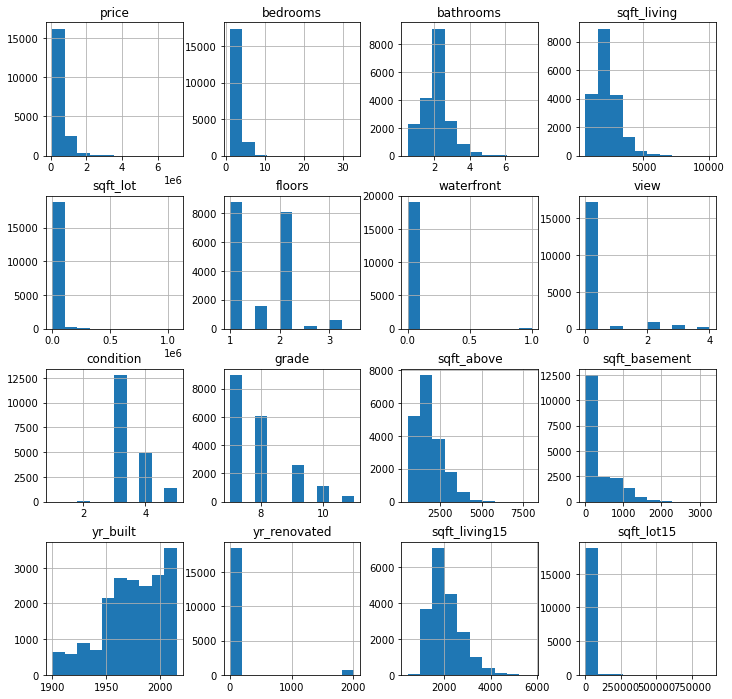

In [56]:
# look into columns
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
df.hist(ax=ax)